In [ ]:
import pandas as pd

def clean_dataset(file_path):
    data = pd.read_csv(file_path, encoding='ISO-8859-1')
    header_row = 2
    data.columns = data.iloc[header_row]
    data = data.drop(index=range(header_row + 1))
    data.columns = [col.strip().lower().replace(' ', '_') for col in data.columns]
    data['fecha_siniestro'] = pd.to_datetime(data['fecha_siniestro'], errors='coerce')
    data = data.dropna(subset=['código_siniestro', 'fecha_siniestro'])

    # Imprimir los nombres de las columnas para verificar
    print("Columnas en el dataset limpio:", data.columns.tolist())

    # Guardar los datos limpios
    data.to_csv('/content/cleaned_siniestros.csv', index=False)

    return data

# Ruta del archivo original
file_path = "/content/BBDD ONSV - SINIESTROS 2021-2022(SINIESTROS).csv"
clean_dataset(file_path)

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def prepare_and_load_data():
    # Cargar datos limpios
    data = pd.read_csv('/content/cleaned_siniestros.csv')

    # Definir la variable de gravedad basándonos en características pre-evento
    def calculate_gravity(row):
        if row['clase_siniestro'].lower() in ['choque mortal', 'atropello mortal']:
            return 2
        elif row['clase_siniestro'].lower() in ['choque', 'atropello']:
            return 1
        else:
            return 0

    data['gravedad'] = data.apply(calculate_gravity, axis=1)

    return data

data = prepare_and_load_data()

# Preparar datos para el modelo
features = data[['hora_siniestro', 'clase_siniestro', 'departamento', 'superficie_de_calzada', '¿existe_señal_vertical?']]
features = pd.get_dummies(features)
target = data['gravedad']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluación
predictions = rf_model.predict(X_test)
print(classification_report(y_test, predictions))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00       176
           1       1.00      1.00      1.00       208

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def prepare_and_load_data():
    # Cargar datos limpios
    data = pd.read_csv('/content/cleaned_siniestros.csv')

    # Definir la variable de gravedad simplificada ajustada
    def calculate_gravity_simple(row):
        if row['clase_siniestro'] in ['ATROPELLO', 'VOLCADURA', 'CHOQUE CON OBJETO FIJO']:
            return 1  # Casos considerados más graves
        else:
            return 0  # Casos considerados menos graves

    data['gravedad_simple'] = data.apply(calculate_gravity_simple, axis=1)
    return data

data = prepare_and_load_data()

# Preparar datos para el modelo
features = data[['hora_siniestro', 'departamento', 'superficie_de_calzada', '¿existe_señal_vertical?']]
features = pd.get_dummies(features)
target = data['gravedad_simple']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Modelo de regresión logística
lr_model = LogisticRegression(max_iter=1000)

# Validación cruzada
cv_scores = cross_val_score(lr_model, features, target, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

# Entrenar y evaluar en el conjunto de prueba
lr_model.fit(X_train, y_train)
predictions = lr_model.predict(X_test)
print(classification_report(y_test, predictions))


Cross-validation scores: [0.734375   0.72395833 0.74479167 0.73629243 0.75195822]
Mean CV score: 0.7382751305483028
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       301
           1       0.29      0.08      0.13        83

    accuracy                           0.76       384
   macro avg       0.54      0.51      0.50       384
weighted avg       0.68      0.76      0.70       384



In [34]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd

# Carga tus datos
data = pd.read_csv('/content/cleaned_siniestros.csv')

# Asumiendo que 'features' y 'target' ya están definidos y adecuadamente preparados
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Escalando las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicando SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Definir y entrenar el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)
predictions_rf = rf_model.predict(X_test_scaled)

# Definir y entrenar el modelo de Regresión Logística
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_smote, y_train_smote)
predictions_lr = lr_model.predict(X_test_scaled)

# Mostrar reportes de clasificación
print("Random Forest con SMOTE:")
print(classification_report(y_test, predictions_rf))
print("Regresión Logística con SMOTE:")
print(classification_report(y_test, predictions_lr))



Random Forest con SMOTE:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       301
           1       0.32      0.20      0.25        83

    accuracy                           0.73       384
   macro avg       0.56      0.54      0.54       384
weighted avg       0.70      0.73      0.71       384

Regresión Logística con SMOTE:
              precision    recall  f1-score   support

           0       0.83      0.63      0.72       301
           1       0.28      0.52      0.36        83

    accuracy                           0.61       384
   macro avg       0.55      0.58      0.54       384
weighted avg       0.71      0.61      0.64       384



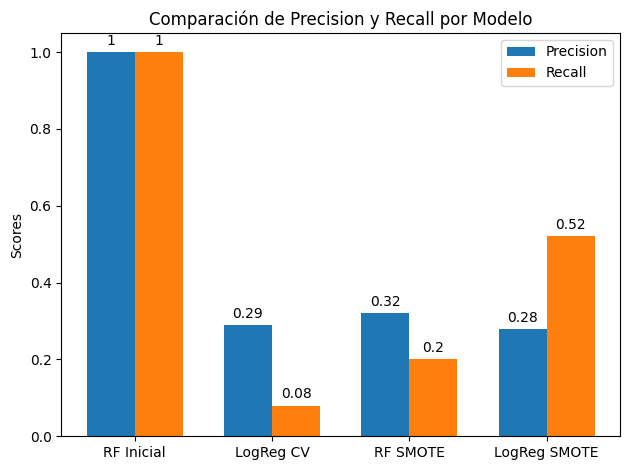

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Datos para el gráfico
labels = ['RF Inicial', 'LogReg CV', 'RF SMOTE', 'LogReg SMOTE']
precision_scores = [1.00, 0.29, 0.32, 0.28]
recall_scores = [1.00, 0.08, 0.20, 0.52]

x = np.arange(len(labels))  # las ubicaciones de las etiquetas
width = 0.35  # ancho de las barras

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, precision_scores, width, label='Precision')
rects2 = ax.bar(x + width/2, recall_scores, width, label='Recall')

# Añadir texto para etiquetas, título y etiquetas personalizadas en el eje X, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparación de Precision y Recall por Modelo')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()